## Predicting Beer Reviews
> Griffin Davis and Sydnee Haney

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE

#### Load in Data

In [124]:
fr = None
try:
    fr = open('../Datasets/beer_ratings.json', 'r')
except:
    try:
        fr = urlopen(
            'https://raw.githubusercontent.com/davisgriffin/Machine_Learning/main/Datasets/beer_ratings.json')
    except:
        raise Exception('Cannot read data')
beer_ratings = pd.read_json(fr, orient='records')
fr.close()

#### Create Dataframes

In [125]:
X = beer_ratings[['beer/ABV', 'user/ageInSeconds',
                  'user/gender', 'beer/style', 'review/overall']]
X = X.dropna()
y = X['review/overall']
X.drop(columns='review/overall', inplace=True)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X

,beer/ABV,user/ageInSeconds,user/gender_Female,user/gender_Male,beer/style_Altbier,beer/style_American Adjunct Lager,beer/style_American Amber / Red Ale,beer/style_American Amber / Red Lager,beer/style_American Barleywine,beer/style_American Black Ale,...,beer/style_Schwarzbier,beer/style_Scotch Ale / Wee Heavy,beer/style_Scottish Ale,beer/style_Scottish Gruit / Ancient Herbed Ale,beer/style_Smoked Beer,beer/style_Tripel,beer/style_Vienna Lager,beer/style_Wheatwine,beer/style_Winter Warmer,beer/style_Witbier
4,7.7,3.581417e+09,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,5.6,1.782054e+09,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,7.4,9.833726e+08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,7.4,1.263823e+09,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,7.4,8.931710e+08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49947,9.0,1.031667e+09,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49951,9.0,1.284822e+09,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49956,9.0,8.941214e+08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49964,9.0,9.497594e+08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create Linear Model

In [126]:
model = LinearRegression().fit(X_train, y_train)
prediction = model.predict(X_test)
score = model.score(X_test, y_test)
print('''R^2: {:.4f}
Mean Absolute Percentage Error: {:.4f}%'''.format(score, MAPE(y_test, prediction)*100))

R^2: 0.1874
Mean Absolute Percentage Error: 14.3596%


#### Visualizing Predictions

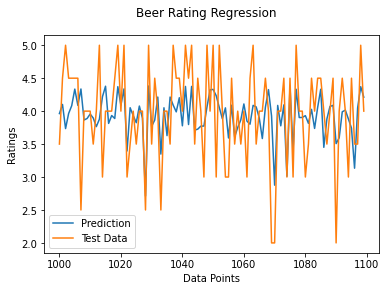

In [127]:
plt.close('all')
x = np.arange(0, len(prediction))
fig, ax = plt.subplots()
ax.plot(x[1000:1100], prediction[1000:1100], label='Prediction')
ax.plot(x[1000:1100], y_test[1000:1100], label='Test Data')
ax.set_xlabel('Data Points')
ax.set_ylabel('Ratings')
fig.suptitle('Beer Rating Regression')
ax.legend()
plt.show()